# Part 3: Finding Combined Weighted Mean

### A single time- series to capture effects of all pollutants

Here we will calculate combined weighted combination of air polluting factors to obtain a single time-series data in new column- 
"tot_pol".

We will use means of individual columns to obtain the weights used to form column "tot_col".

For example, for the weight corresponding to column PM10,

We know that mean of all PM10 readings is 181.41, while the sum of means of all pollutant data readings is 484.87.

Hence weight value for PM10 column will be 181.41/484.87= 0.398

Same process is followed to get weights for remaining columns.

Giving different weights for different columns will result in giving more importance to pollutants with higher concentration and less priority to the remaining.


In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import pandas.plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

In [2]:
file_path = 'C:/Users/Omkar/Desktop/EE798Q/Open pit blasting 01-02-2023 000000 To 01-05-2023 235959.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path , index_col=0)

In [3]:
# Simplify column names
df.columns = ['from', 'to', 'PM10', 'PM2.5', 'NO','NO2','NOX','CO','SO2','NH3','Ozone','Benzene']
# deleting to column as we need only one timestamp column for to be index and we choose it to be from column
df = df.drop('to', axis=1)
# removing last 3 rows as they contaion max , min , avg data instead of actual observations
df = df.iloc[:-3]
df.tail()


,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
#,,,,,,,,,,,
8636,2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.63,10.0,10.7,26.1,0.1
8637,2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.57,10.0,10.4,30.9,0.1
8638,2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.58,9.9,10.5,29.6,0.1
8639,2023-05-01 23:30:00,19.0,11.0,20.8,100.2,70.2,0.58,9.5,10.8,30.0,0.1
8640,2023-05-01 23:45:00,32.0,6.0,21.8,98.8,70.3,NaN,NaN,11.0,33.5,0.1


In [4]:
# conveting timestamp as a string object into a datetime numerical 
date_format = '%Y-%m-%d %H:%M:%S'

# Convert the 'from' column to numerical datetime representation
df['from'] = pd.to_datetime(df['from'], format=date_format)


In [5]:
# set datetime "from" column as an index column
df.set_index('from', inplace=True)
df.head()

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2023-02-01 00:15:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
2023-02-01 00:30:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
2023-02-01 00:45:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
2023-02-01 01:00:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4


In [6]:
df3=df.copy()

In [7]:
df3

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2023-02-01 00:15:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
2023-02-01 00:30:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
2023-02-01 00:45:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
2023-02-01 01:00:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4
...,...,...,...,...,...,...,...,...,...,...
2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.63,10.0,10.7,26.1,0.1
2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.57,10.0,10.4,30.9,0.1
2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.58,9.9,10.5,29.6,0.1


In [8]:
# resample
# df3 = df3.resample('D').mean()
# interpolating
PM10 = df['PM10']
df = df.interpolate(method='spline',order=3)
df.fillna(method='ffill', inplace=True)  # Fill missing values forward
df.fillna(method='bfill', inplace=True)  # Fill missing values backward

In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8640 entries, 2023-02-01 00:00:00 to 2023-05-01 23:45:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM10     6959 non-null   float64
 1   PM2.5    8414 non-null   float64
 2   NO       7271 non-null   float64
 3   NO2      8224 non-null   float64
 4   NOX      8225 non-null   float64
 5   CO       8144 non-null   float64
 6   SO2      7189 non-null   float64
 7   NH3      8314 non-null   float64
 8   Ozone    8187 non-null   float64
 9   Benzene  2445 non-null   float64
dtypes: float64(10)
memory usage: 742.5 KB


In [10]:
weights=[0.398,0.166,0.032,0.123,0.094,3,0.075,0.029,0.078,0.0004]
# Define the weights for each column

In [11]:
# Calculate the weighted mean across the columns
df['tot_pol'] = (df.iloc[:, :10] * weights).sum(axis=1)

In [12]:
df

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene,tot_pol
from,,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,18.1,90.1,56.2,0.310000,8.200000,17.7,28.1,0.4,64.814560
2023-02-01 00:15:00,95.0,35.0,18.1,88.0,55.1,0.330000,8.200000,18.3,27.1,0.4,64.452260
2023-02-01 00:30:00,95.0,35.0,18.1,87.7,55.2,0.380000,8.200000,19.7,24.9,0.4,64.443760
2023-02-01 00:45:00,122.0,34.0,18.1,88.9,55.7,0.380000,8.200000,21.3,21.9,0.4,75.030760
2023-02-01 01:00:00,122.0,34.0,18.1,90.0,55.8,0.380000,8.200000,22.3,16.7,0.4,74.798860
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.630000,10.000000,10.7,26.1,0.1,33.620140
2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.570000,10.000000,10.4,30.9,0.1,33.796440
2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.580000,9.900000,10.5,29.6,0.1,33.940440


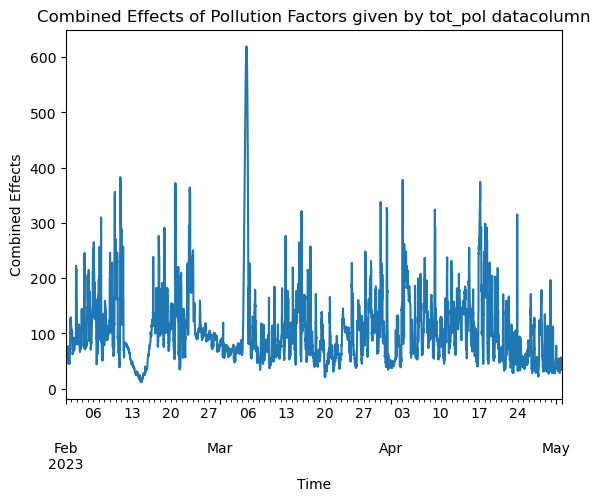

In [13]:
df['tot_pol'].plot()
plt.xlabel('Time')
plt.ylabel('Combined Effects')
plt.title('Combined Effects of Pollution Factors given by tot_pol datacolumn')
plt.show()

Checking for stationarity in the new column data.

In [14]:
 from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['tot_pol'])
print(f'p-value: {adf_test[1]}')

p-value: 5.741498169692062e-13


Such a low p-value implies that tot_pol(combined effective data) also follows time-series stationarity.

In [15]:
# df = df.resample('D').mean()

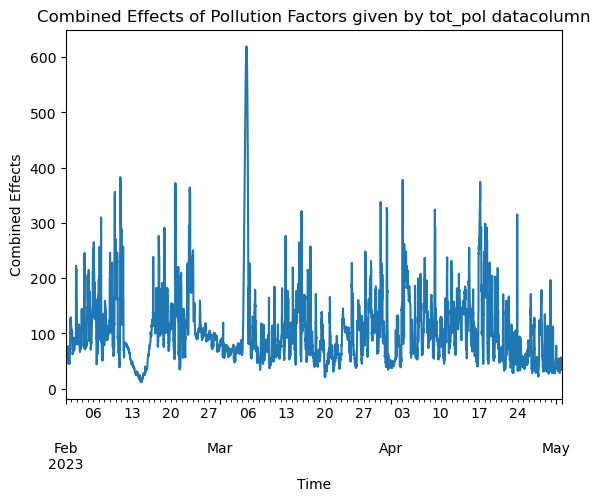

In [16]:
df['tot_pol'].plot()
plt.xlabel('Time')
plt.ylabel('Combined Effects')
plt.title('Combined Effects of Pollution Factors given by tot_pol datacolumn')
plt.show()